In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MultiTargetMazeEnv as mtmz
from MazeEnv.MazeEnv import Rewards
from Utils import make_circular_map, clear_files
from Evaluation import EvalAndSaveCallback, MultiTargetEvalAndSaveCallback
import Evaluation

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [136]:
TOTAL_TIME_STEPS = 100_000 #number of training timesteps
BUFFER_SIZE = 50_000
TIMEOUT_STEPS = 400 # Timeout Steps of each episode 
LEARNING_RATE = 0.0002
EXPLORATION_NOISE_STD = 0.05

REWARDS = Rewards(target_arrival=10, collision=-20, timeout=-10, idle=-0.01)

# EVAL_EPISODES = 30
EVAL_FREQ = 5000
VIDEO_FREQ = 5

# create environment :
tile_size = 0.1
maze_size = mtmz.MazeSize.SQUARE10
map_size = np.dot(maze_size, int(1 / tile_size))
circle_radius = 3
maze_map = make_circular_map(map_size, circle_radius / tile_size)
# maze_map = np.zeros(map_size)

start_loc = (5, 5)
targets = np.genfromtxt("TestTargets/test_coords.csv", delimiter=',')

maze_env = mtmz.MultiTargetMazeEnv(maze_size=maze_size,
                                   maze_map=maze_map,
                                   tile_size=tile_size,
                                   start_loc=start_loc,
                                   target_loc_list=targets,
                                   timeout_steps=TIMEOUT_STEPS,
                                   show_gui=False,
                                   rewards=REWARDS)
maze_env = Monitor(maze_env, filename="logs/MultiTargets/results")

check_env(maze_env)

# create separete evaluation environment:
eval_maze_env =mtmz.MultiTargetMazeEnv(maze_size=maze_size,
                                       maze_map=maze_map,
                                       tile_size=tile_size,
                                       start_loc=start_loc,
                                       target_loc_list=targets,
                                       timeout_steps=TIMEOUT_STEPS,
                                       show_gui=False,
                                       rewards=REWARDS)
 
# create model:
exploration_noise = NormalActionNoise(mean=np.array([0]*8), sigma=np.array([EXPLORATION_NOISE_STD]*8))

model = DDPG(policy="MlpPolicy",
             env=maze_env,
             buffer_size=BUFFER_SIZE,
             learning_rate=LEARNING_RATE,
             action_noise=exploration_noise,
             device=device,
             train_freq=(1, "episode"),
             verbose=0)

# create callback for evaluation
callback = MultiTargetEvalAndSaveCallback(log_dir="logs/MultiTargets",
                                          eval_env=eval_maze_env,
                                          eval_freq=EVAL_FREQ,
                                          eval_video_freq=VIDEO_FREQ,
                                          verbose=1)

In [137]:
# clear old videos: 
clear_files('logs/MultiTargets/*.gif')
clear_files('logs/MultiTargets/*.avi')

In [ ]:
start = time.time()

#clean all movies from the previous run
clear_files('logs/MultiTargets/*_steps.avi')

torch.manual_seed(3295)
model.learn(total_timesteps=TOTAL_TIME_STEPS,
            callback=callback)
 
print("time", time.time() - start)

5000 Steps evaluation, avg reward:-9.74266666666663, avg episode length: 375.26666666666665
--Saving new best model--


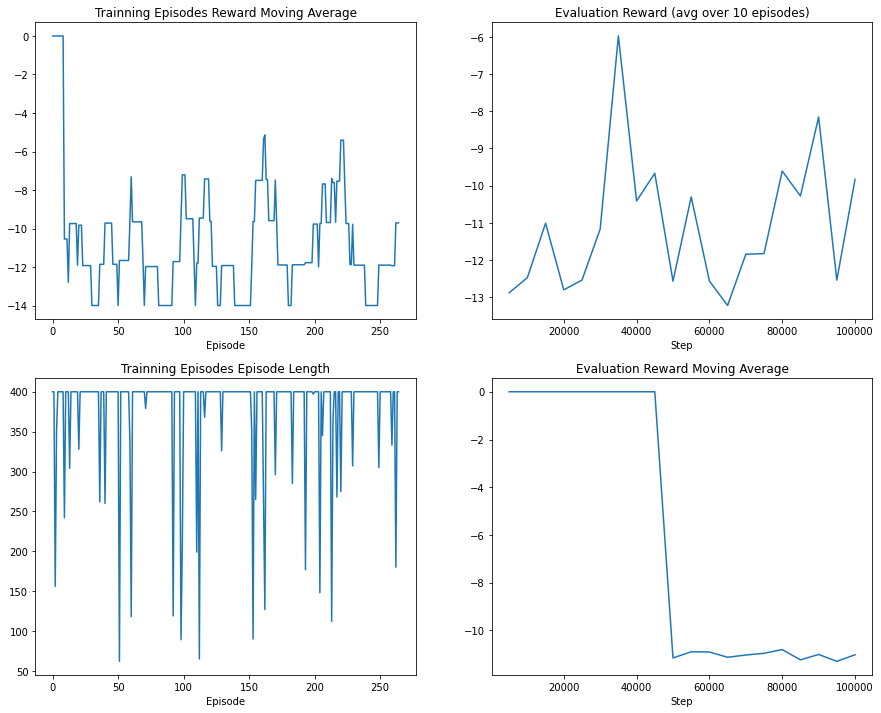

In [133]:
Evaluation.plot_train_eval_results("logs/MultiTargets", EVAL_EPISODES)

In [134]:
from IPython.display import Image
import ipyplot
import glob

# create gifs and plot them:
Evaluation.create_gifs_from_avi("logs/MultiTargets")

gifs = glob.glob("logs/MultiTargets/*_steps.gif")
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=250)


In [135]:
# load best model
best_model = DDPG.load("./logs/MultiTargets/best_model",env=maze_env)

# evaluate for last final episode (random target)
episode_reward = Evaluation.record_model(best_model, eval_maze_env, "logs/MultiTargets/final/final.avi")
print("Final Evaluation Reward:", episode_reward)

Evaluation.create_gifs_from_avi("logs/MultiTargets/final")

gifs = glob.glob("logs/MultiTargets/final/final.gif")
print(gifs)
ipyplot.plot_images(gifs, img_width=250)

Final Evaluation Reward: -13.98999999999996
['logs/MultiTargets/final/final.gif']
